In [7]:
pip install torch torchvision huggingface_hub matplotlib datasets

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars
import numpy as np
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# %%
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # Consider normalizing the data to [-1, 1] or [0, 1]
    # transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform  # Use the defined transform
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform  # Use the defined transform
)

In [24]:
# Create validation split (e.g., 10% of training data)
train_size = int(0.9 * len(training_data))
val_size = len(training_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(training_data, [train_size, val_size])

# %%
# DataLoaders
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2) # Add num_workers
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


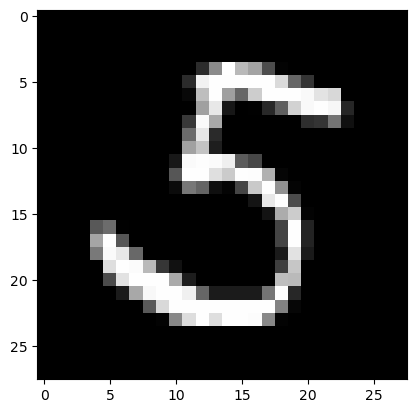

Label: 5


In [25]:
# %%
# Display image and label (moved down for better flow)
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, h_dim=512, z_dim=32): # Increased h_dim, z_dim
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, h_dim)
        self.fc_mu = nn.Linear(h_dim, z_dim)
        self.fc_logvar = nn.Linear(h_dim, z_dim)

        # Decoder
        self.fc2 = nn.Linear(z_dim, h_dim)
        self.fc3 = nn.Linear(h_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h2 = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross Entropy)
    reconstruction_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # KL divergence
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20

train_losses = []
val_losses = []

# Initialize the plot
plt.figure(figsize=(10, 5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
train_line, = plt.plot([], [], label='Train Loss')
val_line, = plt.plot([], [], label='Validation Loss')
plt.legend()
plt.show(block=False) # or plt.show() if not in interactive mode

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    with tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)") as pbar:
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            pbar.set_postfix({'loss': loss.item() / len(data)})

    avg_train_loss = train_loss / len(train_dataloader.dataset)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        with tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)") as pbar:
            for data, _ in pbar:
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                loss = loss_function(recon_batch, data, mu, logvar)
                val_loss += loss.item()
                pbar.set_postfix({'loss': loss.item() / len(data)})

    avg_val_loss = val_loss / len(val_dataloader.dataset)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # Update the plot
    train_line.set_xdata(range(len(train_losses)))
    train_line.set_ydata(train_losses)
    val_line.set_xdata(range(len(val_losses)))
    val_line.set_ydata(val_losses)
    plt.gca().relim()
    plt.gca().autoscale_view()
    plt.gcf().canvas.draw_idle()
    plt.gcf().canvas.flush_events()

print("Finished Training")
plt.ioff() # Turn off interactive mode after training
plt.show()

<IPython.core.display.Javascript object>

Epoch 1/20 (Train):  73%|███████▎  | 612/844 [00:04<00:01, 204.40it/s, loss=132]

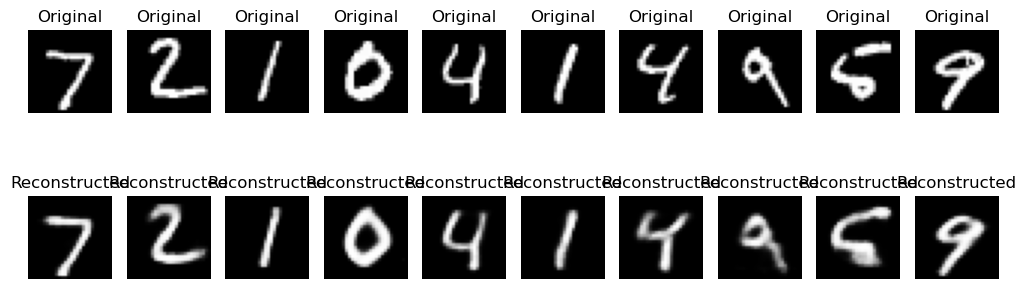

In [28]:
model.eval()
n_samples = 10
with torch.no_grad():
    sample = next(iter(test_dataloader))[0][:n_samples].to(device)
    recon, _, _ = model(sample)
    recon = recon.cpu().view(-1, 28, 28)
    sample = sample.cpu().view(-1, 28, 28)

    fig, axes = plt.subplots(2, n_samples, figsize=(10, 4))
    for i in range(n_samples):
        axes[0, i].imshow(sample[i], cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        axes[1, i].imshow(recon[i], cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

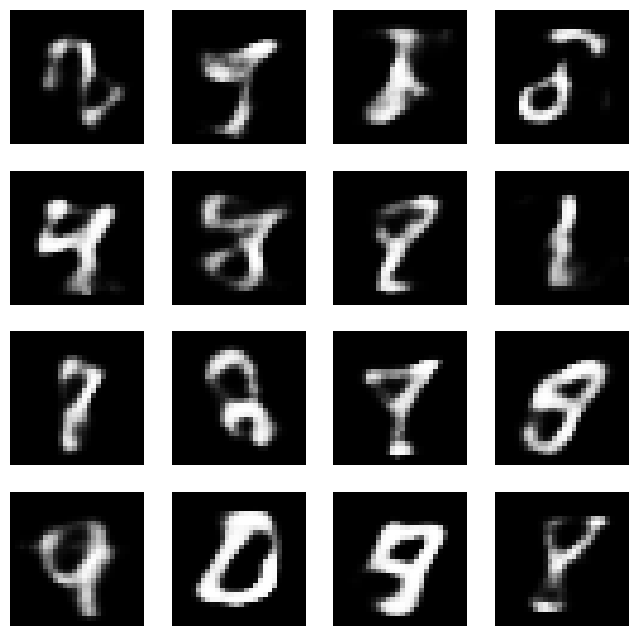

In [29]:
model.eval()
with torch.no_grad():
    z = torch.randn(16, 32).to(device)  # Sample random points in the latent space
    sampled_images = model.decode(z).cpu()
    sampled_images = sampled_images.view(-1, 28, 28)  # Reshape to image dimensions

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for idx, ax in enumerate(axes.flatten()):
        ax.imshow(sampled_images[idx].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()